# Collective progress

**Example notebook for creating anonymised, collective information on progress**

* Before running this notebook, you need to prepare the data you want to assess. To do so, please use the notebook - ""
* For testing, some example data is available in the folder "proc_data"
* Enter the name of the file that you wish to use in the first cell, after that you can run the full notebook with minimal changes. 

In [1]:
# import modules

# system 
import re
import os

# calculation
import pandas as pd
import numpy as np

# plotting
%matplotlib inline
import seaborn
import matplotlib

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils


## LJ notes...

The code below has been tested with
* 'UN-population-data-2017.csv'
* 'PRIMAP-hist_v2.0_Energy-CO2.csv'

TODOs
* clearly define 'proc-data' file format
* decide on final plots
* automatically include the source in plots somehow
 

In [5]:
# USER INPUT

# First, choose which file you want to plot the data for
#data_file_name = 'UN-population-data-2017.csv'
data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'
#data_file_name = 'PRIMAP-hist_UN-2017_calc__CO2-per-population.csv'
#data_file_name = 'WDI2017_GDP-PPP.csv'

# Second, choose which years you are interested in analysing
years_of_interest = ['1990', '2000', '2014']


In [6]:
# DATA READING AND PREP

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# Check the data format
if not utils.verify_data_format(data):
    print('WARNING: The data is not correctly formatted! Please check before continuing!')

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

# tidy up for next stesps
data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

# remove comment below to display the data
#data_years

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 1990, dtype: float64)
upper outliers are: 
country
AUS     259000.0
CAN     430000.0
CHN    2320000.0
DEU     990000.0
ESP     211000.0
FRA     368000.0
GBR     578000.0
IND     559000.0
IRN     204000.0
ITA     410000.0
JPN    1080000.0
KAZ     245000.0
KOR     246000.0
MEX     280000.0
POL     361000.0
RUS    2360000.0
UKR     592000.0
USA    4930000.0
ZAF     278000.0
Name: 1990, dtype: float64
---


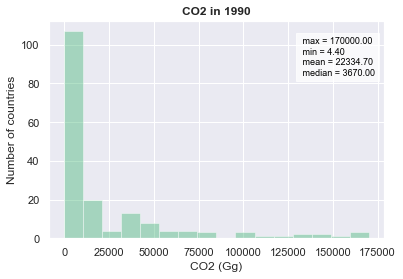

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2000, dtype: float64)
upper outliers are: 
country
AUS     327000.0
BRA     268000.0
CAN     531000.0
CHN    3150000.0
DEU     840000.0
ESP     287000.0
FRA     385000.0
GBR     545000.0
IDN     264000.0
IND     962000.0
IRN     361000.0
ITA     444000.0
JPN    1190000.0
KOR     410000.0
MEX     366000.0
POL     302000.0
RUS    1360000.0
SAU     235000.0
UKR     216000.0
USA    5800000.0
ZAF     336000.0
Name: 2000, dtype: float64
---


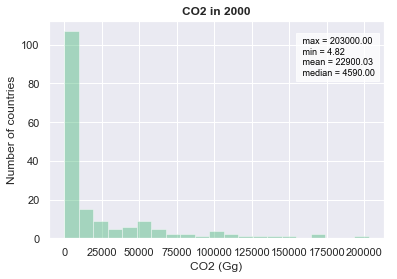

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
ARE     239000.0
AUS     372000.0
BRA     430000.0
CAN     526000.0
CHN    8810000.0
DEU     745000.0
ESP     235000.0
FRA     313000.0
GBR     420000.0
IDN     338000.0
IND    1880000.0
IRN     617000.0
ITA     332000.0
JPN    1200000.0
KAZ     235000.0
KOR     589000.0
MEX     459000.0
MYS     227000.0
POL     287000.0
RUS    1480000.0
SAU     470000.0
THA     299000.0
TUR     305000.0
USA    5380000.0
ZAF     398000.0
Name: 2014, dtype: float64
---


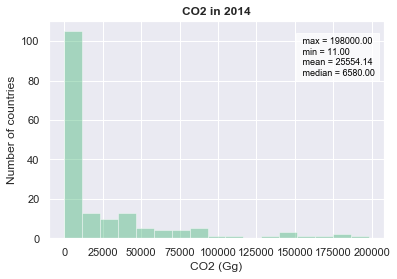

In [7]:
# Plot 1 - make a histogram of absolute data

for selected_year in years_of_interest:
    make_histogram(data_years[selected_year], variable, unit, remove_outliers=True)


Averaging trend over 5 years.
bins set to range(-38, 38, 2)


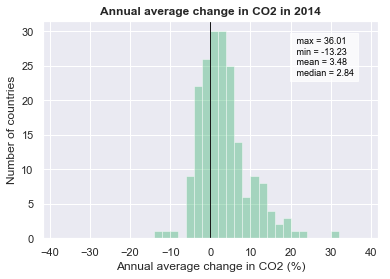

In [8]:
# Plot 2 - trends

# Calculate trends and define plotting params    
# TODO - improve description here. 
trends, rolling_trends, trends_unit = utils.calculate_trends(data_years, num_years_trend=5)
trends_variable = 'Annual average change in ' + variable

# plot the trend in the final year
make_histogram(rolling_trends.iloc[:,-1], trends_variable, trends_unit)


Calculating difference compared to 1990
Calculating difference compared to 2005
---------
All values in the series are the same! Exiting plotting routine for change since 1990
---------
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2000, dtype: float64)
upper outliers are: 
country
GNQ    589.393939
LAO    313.425926
NPL    406.944444
SYC    281.333333
TGO    359.770115
TLS    354.545455
Name: 2000, dtype: float64
---
bins set to range(-252, 252, 21)


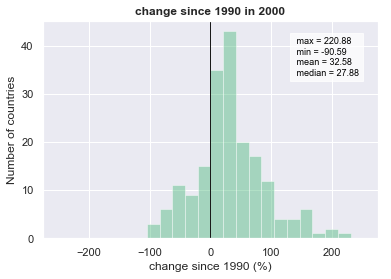

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
BEN     907.168459
GNQ    8006.060606
NPL    1025.000000
QAT     805.172414
TGO     788.888889
Name: 2014, dtype: float64
---
bins set to range(-792, 792, 66)


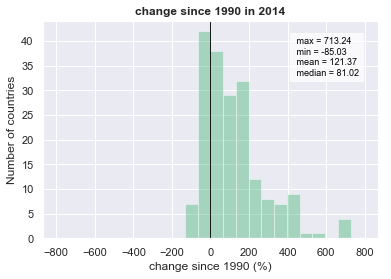

bins set to range(-780, 780, 20)


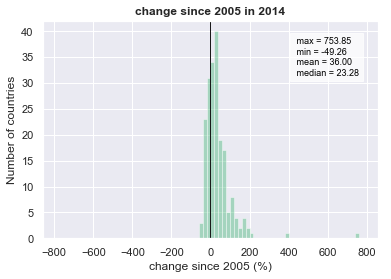

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2014, dtype: float64)
upper outliers are: 
country
AFG    753.846154
MOZ    386.075949
Name: 2014, dtype: float64
---
bins set to range(-216, 216, 18)


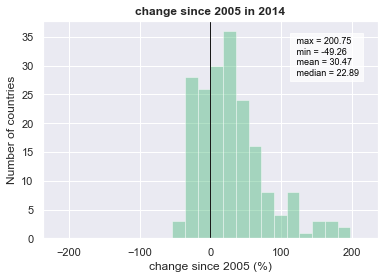

In [9]:
# Plot 3 - change since year X

# run calculations
df_abs_diff_1990, df_perc_diff_1990 = utils.calculate_diff_since_yearX(data_years, '1990')
df_abs_diff_2005, df_perc_diff_2005 = utils.calculate_diff_since_yearX(data_years, '2005')

# make plots
# TODO - titles currently missing necessary information here!
for selected_year in years_of_interest:
    make_histogram(df_perc_diff_1990[selected_year], "change since 1990", "%", remove_outliers=True, kTuk=3)

make_histogram(df_perc_diff_2005.iloc[:,-1], "change since 2005", '%', remove_outliers=False)
make_histogram(df_perc_diff_2005.iloc[:,-1], "change since 2005", '%', remove_outliers=True)


## Below here is code for testing and debugging!

In [ ]:
# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

data.columns

In [5]:
data_years

,2008,2009,2010,2011
country,,,,
AFG,3.076000e+10,3.723000e+10,4.037000e+10,4.284000e+10
AGO,1.129000e+11,1.157000e+11,1.196000e+11,1.243000e+11
ALB,2.342000e+10,2.421000e+10,2.511000e+10,2.575000e+10
ARE,4.311000e+11,4.085000e+11,4.151000e+11,4.368000e+11
ARG,6.464000e+11,6.081000e+11,6.697000e+11,7.099000e+11
ARM,1.908000e+10,1.638000e+10,1.674000e+10,1.753000e+10
ATG,1.907000e+09,1.678000e+09,1.558000e+09,1.530000e+09
AUS,7.617000e+11,7.755000e+11,7.912000e+11,8.100000e+11
AUT,3.197000e+11,3.076000e+11,3.135000e+11,3.223000e+11
